<a href="https://colab.research.google.com/github/saeu5407/Image_Multilabel/blob/main/code/multiclass_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 작업 내용

1. train, valid 7:3으로 분리하여 작업
2. 데이터셋이 부족하여 회전 등 생성 작업을 진행하여 작업
3. 시간관계상 데이터사이즈, 모델링을 최소화하여 작업



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import sys
import random
import tqdm
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D, Concatenate)
# from tensorflow.keras.applications import EfficientNetB0
from keras import metrics
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
"""
이미지 데이터셋 Train,Valid 분리
데이터셋은 한 경로 내에 카테고리별 폴더로 나뉘어야 한다.

as_is_path = 이미지 원본 경로
train_path = 트레이닝 세트 생성 경로
valid_path = 테스트 세트 생성 경로
split_size = 분할 비율
"""
def train_val_split(as_is_path, train_path, valid_path, split_size=0.7):

    # 기존 데이터 카테고리 폴더 확인
    # 카테고리 저장
    fold_ = os.listdir(as_is_path)
    fold_.remove('.DS_Store')

    # train set 폴더 생성
    if os.path.isdir(train_path) == False:
        os.mkdir(train_path)
    for i in fold_:
        if os.path.isdir(train_path + '/' + i) == False:
            os.mkdir(train_path + '/' + i)

    # validation set 폴더 생성
    if os.path.isdir(valid_path) == False:
        os.mkdir(valid_path)
    for i in fold_:
        if os.path.isdir(valid_path + '/' + i) == False:
            os.mkdir(valid_path + '/' + i)

    # split 실행 및 copy하여 적재
    for idx in fold_:
        listfile = os.listdir(as_is_path + '/' + idx)
        train_size = int(len(listfile)*split_size)
        print("{} | train {}, valid {} split".format(idx, train_size, len(listfile)-train_size))
        for fname in listfile[0:train_size]:
            shutil.copyfile(os.path.join(as_is_path + '/' + idx, fname),os.path.join(train_path + '/' + idx, fname))
        for fname in listfile[train_size:]:
            shutil.copyfile(os.path.join(as_is_path + '/' + idx, fname),os.path.join(valid_path + '/' + idx, fname))

In [4]:
# 데이터셋 경로
base_path = '/content/drive/MyDrive/Git/Image_Multilabel'
as_is_path = base_path + '/data/balance'
train_path = as_is_path + '_trd'
valid_path = as_is_path + '_valid'
test_path = base_path + '/data/balance_test'

# train_val_split 함수 실행
#train_val_split(as_is_path, train_path, valid_path, split_size=0.8)

In [5]:
# 전처리(train)
# 이미지 스케일링
trainDataGen = ImageDataGenerator(rescale=1./255, # 이미지 스케일링
                                 rotation_range = 30, # 임의로 이미지를 회전
                                 width_shift_range=0.1, # 임의로 이미지를 수평 이동
                                 height_shift_range=0.1, # 임의로 이미지를 수직 이동
                                 shear_range=0.2, # 임의로 이미지를 변형
                                 zoom_range=0.2, # 임의로 이미지를 확대/축소
                                 horizontal_flip=False, # 수평방향으로 뒤집기
                                 fill_mode='nearest' # 이미지 경계의 바깥 공간을 어떻게 채울지에 대한 파라미터
                                 )

testDataGen = ImageDataGenerator(rescale=1./255)

In [6]:
from glob import glob
"""
MultiLable을 만들기 위한 함수
여기서는 앞에가 color, 뒤에가 item인 black_shirt.png 로 구성되어있기에 목표에 맞게 작업
향후 변경 필요시 columns= / get_dummies 등을 변경하여 사용
"""
def make_multi_lable(data_path):
    data_set = glob(data_path + '/**/*.*', recursive = True)
    dt_f = pd.DataFrame(list(map(lambda x : x.split('/')[-2].split('_'), data_set)), columns=['color','item'])
    dt_f = pd.concat([pd.get_dummies(dt_f['color']), pd.get_dummies(dt_f['item'])], axis=1)
    dt_f_col = list(dt_f.columns)
    dt_f['path'] = data_set
    dt_f
    
    return dt_f, dt_f_col

In [12]:
# 이미지 스케일링
dt_train, dt_train_col = make_multi_lable(train_path)
dt_valid, dt_valid_col = make_multi_lable(valid_path)

# Train Set
trainGenSet = trainDataGen.flow_from_directory(
    train_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Valid Set
testGenSet = testDataGen.flow_from_directory(
    valid_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical'
)

# Test Set
# Valid Set 그대로 셔플 제외하여 사용
finalGenSet = testDataGen.flow_from_directory(
    valid_path,
    target_size=(224,224),
    batch_size=32,
    class_mode=None
)

# White Pants
whiteGenSet = testDataGen.flow_from_directory(
    test_path,
    target_size=(224,224),
    batch_size=32,
    class_mode=None
)

Found 3859 images belonging to 11 classes.
Found 968 images belonging to 11 classes.
Found 968 images belonging to 11 classes.
Found 1 images belonging to 1 classes.


In [15]:
# 모델
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), padding='same', input_shape=(224,224,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# model.add(Flatten())
model.add(GlobalAveragePooling2D())
model.add(Dense(128, activation='relu', name='after_gap'))
model.add(Dropout(0.25))
model.add(Dense(11, activation='softmax'))

# 학습
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

model.summary()

# fig_generator
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2000)
checkpoint = ModelCheckpoint(base_path + '/model/multiclass_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.fit_generator(
    trainGenSet,
    steps_per_epoch=43,
    epochs=5,
    validation_data=testGenSet,
    validation_steps=10,
    callbacks=[early_stopping, checkpoint]
)

scores = model.evaluate_generator(testGenSet)
print(scores)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 56, 56, 128)       0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 56, 56, 256)      

In [19]:
model_ = load_model(base_path + '/model/multiclass_model.h5')
pred = model_.predict_generator(finalGenSet, steps=1)
pred_df = pd.DataFrame(pred, columns = trainGenSet.class_indices)
pred_df['path'] = dt_valid['path'][0:32]

멀티레이블과는 다르게 각각이 하나씩 맵핑되어 있는 걸 확인할 수 있습니다.

멀티레이블 : 블랙, 드레스
멀티클래스 : 블랙드레스

,black_dress,black_pants,black_shirt,blue_dress,blue_pants,blue_shirt,red_dress,red_pants,red_shirt,white_dress,white_shirt,path
4,9.056885,2.071847,14.38857,45.011108,19.897383,7.249785,0.035366,0.075118,0.006163,2.119858,0.087912,/content/drive/MyDrive/Git/Image_Multilabel/da...


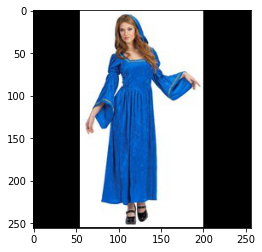

In [22]:
import matplotlib.pyplot as plt
j = 4
a = plt.imread(pred_df['path'][j])
plt.imshow(a)
pred_df.iloc[j:j+1,:] * 100

멀티레이블에서는 성능적인 문제로 화이트팬츠를 예측하지 못했다면
멀티클래스에서는 애초에 화이트팬츠라는 카테고리가 없기에 예측할 수 없습니다.

   black_dress  black_pants  black_shirt  ...  red_shirt  white_dress  white_shirt
0     0.583323      1.86263     0.585009  ...    0.08931     3.324299    88.709076

[1 rows x 11 columns]


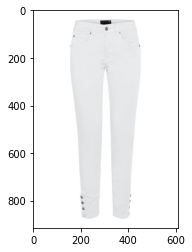

In [23]:
pred = model_.predict_generator(whiteGenSet, steps=1)
pred_df = pd.DataFrame(pred, columns = trainGenSet.class_indices)
print(pred_df*100)
a = plt.imread(glob(test_path + '/testdata/*')[0])
plt.imshow(a)